In [2]:
# Convolutional layer implementation
# The constructor takes as inputs the number of kernels of the convolutional layer and their size. 
# use only squared kernels of size kernel_size by kernel_size
class ConvolutionLayer:
    def __init__(self, kernel_num, kernel_size):
        self.kernel_num = kernel_num
        self.kernel_size = kernel_size
        # generate random filters of shape (kernel_num, kernel_size, kernel_size) and 
        # divide each element by the squared kernel size for normalization.
        self.kernels = np.random.randn(kernel_num, kernel_size, kernel_size)/(kernel_size**2)
        
    # yield the portions of the images on which to perform each convolution step
    def patches_generator(self, image):
        image_h, image_w = image.shape
        self.image = image
        for h in range(image_h-self.kernel_size+1):
            for w in range(image_w-self.kernel_size+1):
                patch = image[h:(h+self.kernel_size), w:(w+self.kernel_size)]
                yield patch, h, w
                
    # carries out the convolution for each patch generated by the method above.
    def forward_prop(self, image):
        image_h, image_w = image.shape
        convolution_output = np.zeros((image_h-self.kernel_size+1, image_w-self.kernel_size+1, self.kernel_num))
        for patch, h, w in self.patches_generator(image):
            convolution_output[h,w] = np.sum(patch*self.kernels, axis=(1,2))
        return convolution_output
    
    # compute the gradient of the loss function with respect to each weight of the layer 
    # and updates the weights’ values correspondingly
    def back_prop(self, dE_dY, alpha):
        dE_dk = np.zeros(self.kernels.shape)
        for patch, h, w in self.patches_generator(self.image):
            for f in range(self.kernel_num):
                dE_dk[f] += patch * dE_dY[h, w, f]
        self.kernels -= alpha*dE_dk
        return dE_dk

In [3]:
# Max Pooling Layer Implementation
class MaxPoolingLayer:
    def __init__(self, kernel_size):
        self.kernel_size = kernel_size
    
    def patches_generator(self, image):
        output_h = image.shape[0] // self.kernel_size
        output_w = image.shape[1] // self.kernel_size
        self.image = image
    
        for h in range(output_h):
            for w in range(output_w):
                patch = image[(h*self.kernel_size):(h*self.kernel_size+self.kernel_size), (w*self.kernel_size):(w*self.kernel_size+self.kernel_size)]
                yield patch, h, w
                
    def forward_prop(self, image):
        image_h, image_w, num_kernels = image.shape
        max_pooling_output = np.zeros((image_h//self.kernel_size, image_w//self.kernel_size, num_kernels))
        for patch, h, w in self.patches_generator(image):
            max_pooling_output[h,w] = np.amax(patch, axis=(0,1))
        return max_pooling_output
    
    def back_prop(self, dE_dY):
        dE_dk = np.zeros(self.image.shape)
        for patch,h,w in self.patches_generator(self.image):
            image_h, image_w, num_kernels = patch.shape
            max_val = np.amax(patch, axis=(0,1))
            
            for idx_h in range(image_h):
                for idx_w in range(image_w):
                    for idx_k in range(num_kernels):
                        if patch[idx_h,idx_w,idx_k] == max_val[idx_k]:
                            dE_dk[h*self.kernel_size+idx_h, w*self.kernel_size+idx_w, idx_k] = dE_dY[h,w,idx_k]
            return dE_dk

In [4]:
# Sigmoid Layer Implementation
# The softmax layer flattens the output volume fed by the max pooling and outputs 10 values. 
# They can be interpreted as the probability of an image corresponding to the digits 0–9
class SoftmaxLayer:
    def __init__(self, input_units, output_units):
        self.weight = np.random.randn(input_units, output_units)/input_units
        self.bias = np.zeros(output_units)

    def forward_prop(self, image):
        self.original_shape = image.shape
        image_flattened = image.flatten()
        self.flattened_input = image_flattened
        first_output = np.dot(image_flattened, self.weight) + self.bias
        self.output = first_output
        softmax_output = np.exp(first_output) / np.sum(np.exp(first_output), axis=0)
        return softmax_output

    def back_prop(self, dE_dY, alpha):
        for i, gradient in enumerate(dE_dY):
            if gradient == 0:
                continue
            transformation_eq = np.exp(self.output)
            S_total = np.sum(transformation_eq)

            dY_dZ = -transformation_eq[i]*transformation_eq / (S_total**2)
            dY_dZ[i] = transformation_eq[i]*(S_total - transformation_eq[i]) / (S_total**2)

            dZ_dw = self.flattened_input
            dZ_db = 1
            dZ_dX = self.weight

            dE_dZ = gradient * dY_dZ

            dE_dw = dZ_dw[np.newaxis].T @ dE_dZ[np.newaxis]
            dE_db = dE_dZ * dZ_db
            dE_dX = dZ_dX @ dE_dZ

            self.weight -= alpha*dE_dw
            self.bias -= alpha*dE_db

            return dE_dX.reshape(self.original_shape)

In [5]:
def CNN_forward(image, label, layers):
    output = image/255.
    for layer in layers:
        output = layer.forward_prop(output)
    # Compute loss (cross-entropy) and accuracy
    loss = -np.log(output[label])
    accuracy = 1 if np.argmax(output) == label else 0
    return output, loss, accuracy

In [6]:
def CNN_backprop(gradient, layers, alpha=0.05):
    grad_back = gradient
    for layer in layers[::-1]:
        if type(layer) in [ConvolutionLayer, SoftmaxLayer]:
            grad_back = layer.back_prop(grad_back, alpha)
        elif type(layer) == MaxPoolingLayer:
            grad_back = layer.back_prop(grad_back)
    return grad_back

In [7]:
def CNN_training(image, label, layers, alpha=0.05):
    # Forward step
    output, loss, accuracy = CNN_forward(image, label, layers)

    # Initial gradient
    gradient = np.zeros(10)
    gradient[label] = -1/output[label]

    # Backprop step
    gradient_back = CNN_backprop(gradient, layers, alpha)

    return loss, accuracy

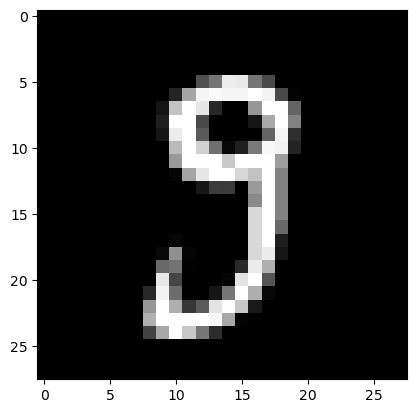

(28, 28)


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Test the convolutions with 1 image, to put in the article
# Test
df_train = pd.read_csv('train.csv')
img = df_train.iloc[40,:].values[1:]
img = np.reshape(img,(28,28))
plt.imshow(img, cmap='gray')
plt.show()
print(img.shape)
# plt.savefig('images/original_image.png', format='png', dpi=1200)

In [10]:
# Test with a convolution of 16 filters of size 3x3
my_conv = ConvolutionLayer(32,3)
output = my_conv.forward_prop(img)
# See the dimensions of the output volume, they follow the usual formula
print(output.shape)

(26, 26, 32)


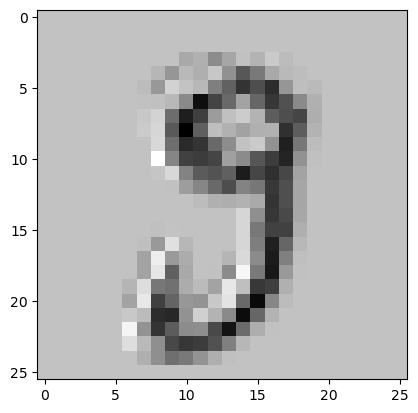

In [12]:
# Plot 16th volume after the convolution
plt.imshow(output[:,:,15], cmap='gray')
plt.show()
# plt.savefig('images/image_convolved.png', format='png', dpi=1200)